# Diffusion Model Final Project

Akash Piya

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cuda'
default_dir = "/kaggle/input/hw5-dataset/"

/kaggle/input/hw5-dataset/cifar10_train.hdf5
/kaggle/input/hw5-dataset/cifar100_train.hdf5
/kaggle/input/hw5-dataset/cifar10_def_data.npy
/kaggle/input/hw5-dataset/cifar10_test.hdf5
/kaggle/input/hw5-dataset/cifar10_def_labels.npy
/kaggle/input/hw5-dataset/cifar100_test.hdf5
/kaggle/input/hw5-dataset/MNIST_labels.npy
/kaggle/input/hw5-dataset/MNIST_data.npy


Below are several convenient helper functions. Their function should be self-explanatory.

In [16]:
def get_data():
    ins = torch.Tensor(np.float32(np.load(default_dir+'MNIST_data.npy'))) / 255
    labels = torch.Tensor(np.float32(np.load(default_dir+'MNIST_labels.npy'))).reshape(-1, 1)
    data = torch.hstack([ins, labels])
    train = data[:50000]
    val = data[50000:55000]
    test = data[55000:]
    return train, val, test

def convert_to_dataloader(train, val, test, config):
    a = DataLoader(train, batch_size=config['batch_size'], shuffle=True)
    b = DataLoader(val, batch_size=val.shape[0], shuffle=True)
    c = DataLoader(test, batch_size=test.shape[0],shuffle=True)
    return a,b,c

def display_images(data, nrows, ncols, titles=None):
    plt.figure(figsize=(ncols*2, nrows*2))
    for i in range(min(nrows * ncols, data.shape[0])):
        plt.subplot(nrows, ncols, i+1)
        plt.tight_layout()
        if titles:
            plt.title(titles[i])
        plt.imshow(data[i].squeeze(), cmap='gray')
    plt.show()

Defined below are FID functions. `FID_dataset` finds the FID score between an arbitrary number of samples and entire dataset.

In [17]:
def FID_dataset(samples, testing):
    data1 = samples.detach().cpu().numpy().reshape(-1, 784)
    data2 = testing.detach().cpu().numpy().reshape(-1, 784)
    mu_1 = np.mean(data1, axis=0).reshape(-1, 784)
    mu_2 = np.mean(data2, axis=0).reshape(-1, 784)
    sigma_1 = np.cov(data1, rowvar=False)
    sigma_2 = np.cov(data2, rowvar=False)
    return FID(mu_1, mu_2, sigma_1, sigma_2)
    
def FID(mean_g, mean_d, std_g, std_d):
    means = np.sum((mean_g - mean_d)**2)
    tr = np.trace(std_g) + np.trace(std_d)
    Q = mat_root(std_g).dot(mat_root(std_d))
    f_term = -2 * np.trace(mat_root(np.matmul(Q, Q.T)))
    return means + tr + f_term

# This function finds the square root of a matrix
# assuming it is symmetric
def mat_root(x):
    evalues, evectors = np.linalg.eigh(x)
    evalues = np.clip(evalues, a_min=0, a_max=None)
    evalues = np.sqrt(evalues)
    return evectors @ np.diag(evalues) @ evectors.T

## Part 1

### (a)

`GaussianFourierProjection` creates a characteristic noise for a specific time. The parameters for this model aren't updated, and remain static throughout training and testing. Each output is a concatenation of a sin and cos function applied to random noise. The functions are used to constrain the data between $-1$ and $1$. Furthermore, the splitting of sin and cos, as opposed to just sin or cos, adds another degree of freedom to encode the time step into the model. The `GaussianFourierProjection` model essential encodes the time-step information into the input so that the network $F$ can receive the data and timestep together in a succinct way. Hence, the network can associate periodic noise in the data to a specific time step.

`ScoreNet` is a U-Net Architecture that models $F$. In this notebook, it is used to either predict $\mu(x_t, \theta)$ or $e(x_t, \theta)$. The `ScoreNet` is like a convolutional neural network except it uses several GroupNorms instead of MaxPools and after each convolution is a standard DenseNet. Furthermore, the latter half of the network, in addition to the previous layer's output, accepts an output from it's corresponding layer in the first half. Lastly, the `ScoreNet` seems to use the Swish Activation function. 

In [18]:
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x * self.W * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""
    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256, group_num=4,eps_model=False):
        super().__init__()
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))
        self.eps_model = eps_model
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(group_num, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(group_num, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(group_num, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(group_num, num_channels=channels[3])

        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(group_num, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(group_num, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(group_num, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.rho = nn.Parameter(torch.tensor([1.0, 1.0], requires_grad=True))


    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))

        h1 = self.conv1(x) # ...
        h1 += self.dense1(embed) #...
        h1 = self.gnorm1(h1) # ...
        h1 = self.act(h1) # ...
        h2 = self.conv2(h1) # ...
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        h = self.tconv4(h4) # ...
        h += self.dense5(embed) # ...
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1)) # ...
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))
        
        if self.eps_model:
            return h
        else:
            return self.rho[0] * (x - self.rho[1] * h)

In [19]:
class Diffusion(nn.Module):
    def __init__(self, model, n_steps, device, min_beta, max_beta):
        super().__init__()
        
        self.n_steps = n_steps
        # All beta, alpha, alpha_bar are padded with an extra element in the 0th index
        self.beta = torch.linspace(min_beta, max_beta, n_steps)
        self.beta = torch.hstack([torch.Tensor([0]), self.beta]).to(device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, 0)
        self.device = device
        self.mu = model.to(device)
    
    def forward_process(self, x_0, t):
        """
        Given an $x_0, t$ outputs $x_{t-1}, x_{t}$. It first computes $x_{t-1}$ then $q(x_t|x_{t-1})$.
        """
        x_t1 = x_0 * torch.sqrt(self.alpha_bar[t-1]) + torch.randn_like(x_0,requires_grad=False) * torch.sqrt(1-self.alpha_bar[t-1])
        x_t = torch.sqrt(self.alpha[t]) * x_t1 + torch.randn_like(x_0, requires_grad=False) * torch.sqrt(1-self.alpha[t])

        return x_t1, x_t
    
    def predict_mu(self, xt, t):
        """
        Utilizes the `ScoreNet` network to determine $\mu(x_t, t; \theta)$
        """
        t = t.reshape(-1, 1)
        return self.mu(xt, t)
    
    def forward_direct(self, x_0):
        """
        Given $x_0$ directly computes $x_t$ and returns the randomly sampled
        $t$ as well. $t$ ranges from $1$ to $N-steps$.
        """
        n = x_0.shape[0]
        t = torch.randint(1, self.n_steps+1, size=(n,1,1,1),requires_grad=False).to(self.device)
        randn = torch.randn_like(x_0,requires_grad=False)
        x_t = x_0 * torch.sqrt(self.alpha_bar[t]) + randn * torch.sqrt(1-self.alpha_bar[t])
        return x_t, t
    
    def to_T(self, x_0):
        """
        Converts samples of x_0 directly to x_T, which should be Gaussian noise
        """
        n = x_0.shape[0]
        t = (self.n_steps * torch.ones(n, 1, 1, 1).int()).to(self.device)
        x_t = x_0 * torch.sqrt(self.alpha_bar[t]) + torch.randn_like(x_0,requires_grad=False) * torch.sqrt(1-self.alpha_bar[t])
        return x_t
    
    def forward_high_var(self, x0):
        """
        Does the forward pass of the model from Part 1
        """
        n = x0.shape[0]
        ts = torch.randint(1, self.n_steps+1, size=(n,1,1,1),requires_grad=False).to(self.device)
        xt_minus, xt = self.forward_process(x0, ts)
        
        return xt_minus, xt, self.predict_mu(xt, ts), ts
    
        
    def mse_loss_high_var(self, xtminus, mu_t, t):
        """
        Loss function for Part 1. 
        """
        t = t.squeeze()
        diff = xtminus - mu_t
        numerator = torch.mean(diff*diff,dim=(1,2,3))
        return numerator / (2 * (1 - self.alpha[t.reshape(-1)]))
    
    def decode(self, x_T):
        """
        Given an $x_T$, that is, pure Gaussian noise, this runs through the reverse 
        process removing noise
        """
        with torch.no_grad():
            x_i = x_T
            for t in range(self.n_steps, 0, -1):
                expanded_t = (t * torch.ones(x_i.shape[0], 1, 1, 1).int()).to(self.device)
                mu = self.predict_mu(x_i, expanded_t)
                z = torch.randn_like(x_i).to(self.device)
                std = torch.sqrt(1 - self.alpha[expanded_t])
                x_i = mu + std * z
            return x_i
    
    def sample(self, num_samples):
        """
        Generates random noise, runs through the reverse process, and outputs the results
        Satisfies the requirements of Part 1 (h)
        """
        x = torch.randn((num_samples,1,28,28),requires_grad=False).to(self.device)
        return self.decode(x)


The cell below sets the desired hyperparameters and defines a function that runs the training for an initial model with the specified hyperparameters.

In [28]:
def create_config_highvar():
    config = {}
    config['T'] = 200
    config['batch_size'] = 100
    config['beta_min'] = 0.0001
    config['beta_max'] = 0.1
    config['device'] = 'cuda'
    config['num_epochs'] = 60
    config['model'] = 'standard' # either 'standard' or 'epsilon'
    return config


def run_epochs_high_var(config):
    train, val, test = convert_to_dataloader(*get_data(),config)
    snet = ScoreNet().to(config['device'])
    diff = Diffusion(snet, config['T'],config['device'],config['beta_min'],config['beta_max']).to(config['device'])
    
    #optimizer = torch.optim.Adam(diff.parameters())
    rho_params = []
    other_params = []

    for name, param in diff.named_parameters():
        if name == "mu.rho":
            rho_params.append(param)
        else:
            other_params.append(param)

    optimizer = torch.optim.Adam([
        {
            'params' : rho_params,
            'lr' : 2,
        },
        {
            'params' : other_params,
            'lr' : 0.001,
        }
    ])

    
    for epoch in range(config['num_epochs']):
        diff.train()
        train_loss = []
        # changing the learning rate for rho
        if epoch % 20 == 0:
            optimizer.param_groups[0]['lr'] /= 10
            print(f"current lr: {optimizer.param_groups[0]['lr']}")
        
        for batch_idx, batch in enumerate(train):
            x = batch[:, :-1].to(config['device'])
            x = x.reshape(-1, 1, 28, 28)
            y = batch[:, -1]
            xt_minus, xt, mu, ts = diff.forward_high_var(x)
            optimizer.zero_grad()
            loss = torch.mean(diff.mse_loss_high_var(xt_minus, mu, ts))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
            
        with torch.no_grad():
            diff.eval()
            data = next(iter(val))
            x = data[:, :-1]
            x = x.reshape(-1, 1, 28, 28).to(config['device'])
            y = data[:, -1]
            xt_minus, xt, mu, ts = diff.forward_high_var(x)

            loss = torch.mean(diff.mse_loss_high_var(xt_minus, mu, ts))
            print(f"Epoch {epoch} | Train Loss: {torch.mean(torch.Tensor(train_loss))} | Val Loss: {loss.item()}")
    return diff

Trains the model

In [29]:
diffusion_highvar = run_epochs_high_var(create_config_highvar())

current lr: 0.2
Epoch 0 | Train Loss: 2.177564859390259 | Val Loss: 0.49561598896980286
Epoch 1 | Train Loss: 0.49702128767967224 | Val Loss: 0.49867263436317444
Epoch 2 | Train Loss: 0.4989296793937683 | Val Loss: 0.5232324004173279
Epoch 3 | Train Loss: 0.4978479743003845 | Val Loss: 0.49944931268692017
Epoch 4 | Train Loss: 0.4983130097389221 | Val Loss: 0.49959489703178406
Epoch 5 | Train Loss: 0.4987841546535492 | Val Loss: 0.4986814260482788
Epoch 6 | Train Loss: 0.4966079294681549 | Val Loss: 0.5146519541740417
Epoch 7 | Train Loss: 0.4968322515487671 | Val Loss: 0.4950503706932068
Epoch 8 | Train Loss: 0.4966719448566437 | Val Loss: 0.4965740740299225
Epoch 9 | Train Loss: 6.219987869262695 | Val Loss: 0.599576473236084
Epoch 10 | Train Loss: 0.5101218819618225 | Val Loss: 0.4974243938922882
Epoch 11 | Train Loss: 0.4976634383201599 | Val Loss: 0.4987994134426117
Epoch 12 | Train Loss: 0.4976961016654968 | Val Loss: 0.4975752830505371
Epoch 13 | Train Loss: 0.49765509366989136 

The code below samples random noise and generates 1000 images. It computes the FID score between the samples and the true data, while also displaying 20 of these generated samples.

FID Score: 13.659463527927741


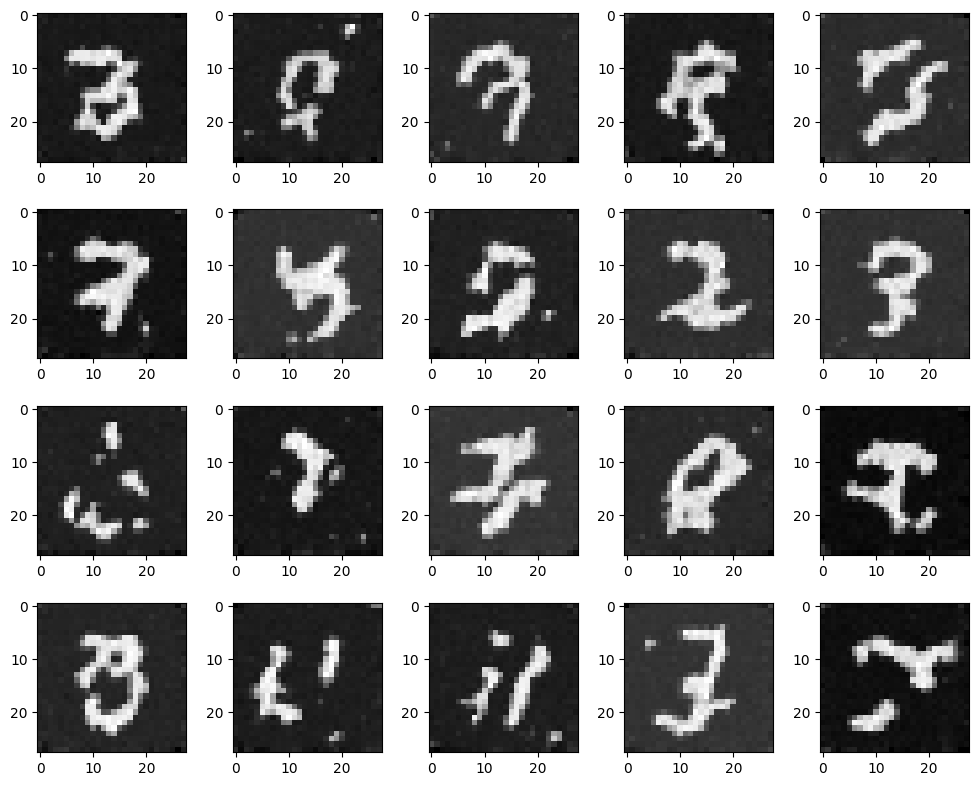

In [76]:
samples = diffusion_highvar.sample(1000)
_, _, test = convert_to_dataloader(*get_data(),create_config_highvar())
test = next(iter(test))[:, :-1]
print(f"FID Score: {FID_dataset(samples, test)}")
display_images(samples.detach().cpu(), 4, 5)

To reduce the variance, I reduce the number of time-steps. This would reduce the variance of our estimate of the loss, but it might make for a worse model overall. This is because we estimate the loss by sampling random time steps. If we simply have less time steps then our sampling should be more accurate. I follow a similar process to above except with different hyperparameters.

In [31]:
def create_config_lowvar():
    config = {}
    config['T'] = 100
    config['batch_size'] = 100
    config['beta_min'] = 0.0001
    config['beta_max'] = 0.1
    config['device'] = 'cuda'
    config['num_epochs'] = 60
    config['model'] = 'standard' # either 'standard' or 'epsilon'
    return config

def run_epochs_low_var(config):
    train, val, test = convert_to_dataloader(*get_data(),config)
    snet = ScoreNet().to(config['device'])
    diff = Diffusion(snet, config['T'],config['device'],config['beta_min'],config['beta_max']).to(config['device'])
    
    #optimizer = torch.optim.Adam(diff.parameters())
    rho_params = []
    other_params = []

    for name, param in diff.named_parameters():
        if name == "mu.rho":
            rho_params.append(param)
        else:
            other_params.append(param)
    
    optimizer = torch.optim.Adam([
        {
            'params' : rho_params,
            'lr' : 2,
        },
        {
            'params' : other_params,
            'lr' : 0.001,
        }
    ])

    
    for epoch in range(config['num_epochs']):
        diff.train()
        train_loss = []
        # changing the learning rate for rho
        if epoch % 20 == 0:
            optimizer.param_groups[0]['lr'] /= 10
            print(f"current lr: {optimizer.param_groups[0]['lr']}")
        
        for batch_idx, batch in enumerate(train):
            x = batch[:, :-1].to(config['device'])
            x = x.reshape(-1, 1, 28, 28)
            y = batch[:, -1]
            xt_minus, xt, mu, ts = diff.forward_high_var(x)
            optimizer.zero_grad()
            loss = torch.mean(diff.mse_loss_high_var(xt_minus, mu, ts))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
            
        with torch.no_grad():
            diff.eval()
            data = next(iter(val))
            x = data[:, :-1]
            x = x.reshape(-1, 1, 28, 28).to(config['device'])
            y = data[:, -1]
            xt_minus, xt, mu, ts = diff.forward_high_var(x)
            
            loss = torch.mean(diff.mse_loss_high_var(xt_minus, mu, ts))
            print(f"Epoch {epoch} | Train Loss: {torch.mean(torch.Tensor(train_loss))} | Val Loss: {loss.item()}")
    return diff

As one can see below, decreasing $T$ has resulted in a somewhat lower FID score. Furthermore, the generated samples look more clean and refined than the previous model

In [32]:
diffusion_lowvar = run_epochs_low_var(create_config_lowvar())

current lr: 0.2
Epoch 0 | Train Loss: 11.096773147583008 | Val Loss: 0.5271919965744019
Epoch 1 | Train Loss: 0.49656835198402405 | Val Loss: 0.4911142587661743
Epoch 2 | Train Loss: 0.4910588264465332 | Val Loss: 0.49017342925071716
Epoch 3 | Train Loss: 0.4907398521900177 | Val Loss: 0.489201158285141
Epoch 4 | Train Loss: 0.49051380157470703 | Val Loss: 0.4890599548816681
Epoch 5 | Train Loss: 0.49071186780929565 | Val Loss: 0.4893335700035095
Epoch 6 | Train Loss: 0.49081751704216003 | Val Loss: 0.4972134530544281
Epoch 7 | Train Loss: 0.493049293756485 | Val Loss: 0.4889886677265167
Epoch 8 | Train Loss: 0.49300870299339294 | Val Loss: 0.490257203578949
Epoch 9 | Train Loss: 0.49292993545532227 | Val Loss: 0.49822524189949036
Epoch 10 | Train Loss: 0.4901496469974518 | Val Loss: 0.4876287877559662
Epoch 11 | Train Loss: 0.49111032485961914 | Val Loss: 0.48853427171707153
Epoch 12 | Train Loss: 0.4903281629085541 | Val Loss: 0.4900957942008972
Epoch 13 | Train Loss: 0.4879996180534

FID Score: 11.143103954460756


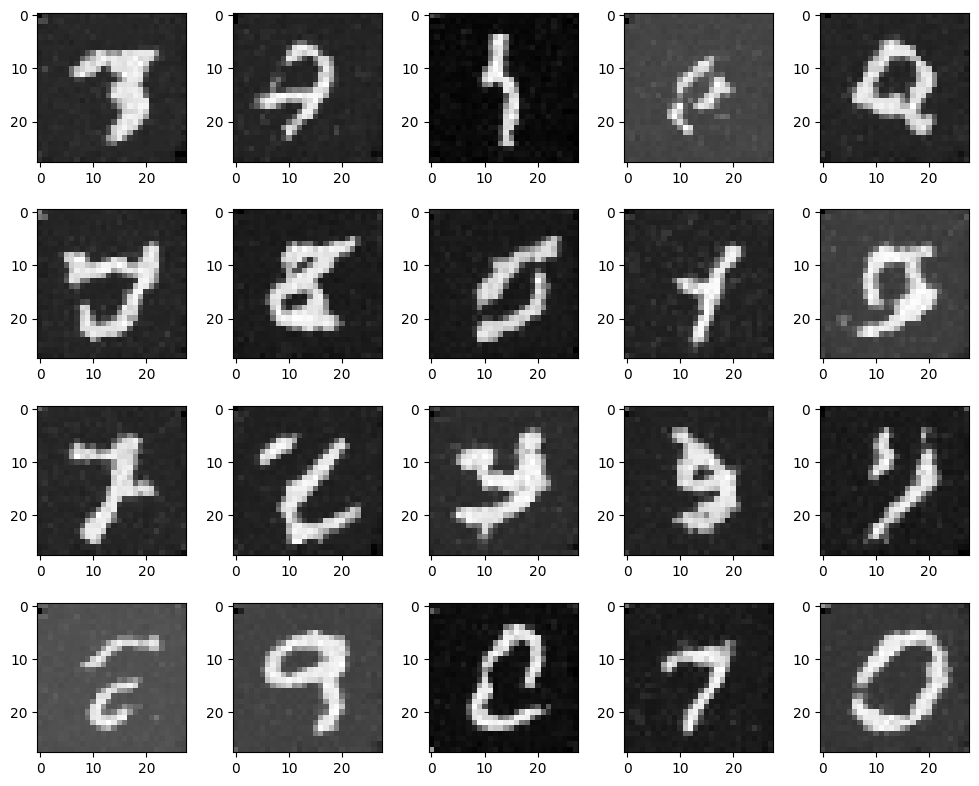

In [79]:
samples = diffusion_lowvar.sample(1000)
_, _, test = convert_to_dataloader(*get_data(),create_config_highvar())
test = next(iter(test))[:, :-1]
print(f"FID Score: {FID_dataset(samples, test)}")
display_images(samples.detach().cpu(), 4, 5)

## Part 2

To accomodate the change in loss function as well as the change in the ScoreNet itself, I've create a new Diffusion Model class called `Opt_Diffusion`.

In [80]:
class Opt_Diffusion(nn.Module):
    def __init__(self, model, n_steps, device, min_beta, max_beta):
        super().__init__()
        
        self.n_steps = n_steps
        self.beta = torch.linspace(min_beta, max_beta, n_steps)
        self.beta = torch.hstack([torch.Tensor([0]), self.beta]).to(device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, 0)
        self.device = device
        self.mu = model.to(device)
    
    def predict_eps(self, xt, t):
        """
        Utilizes the neural network to determine $e(x_t, t; \theta)$
        """
        t = t.reshape(-1, 1)
        return self.mu.forward(xt, t)
        
    def forward_direct(self, x_0):
        """
        Given $x_0$ directly computes $x_t$ and returns the randomly sampled
        $t$ as well. $t$ ranges from $1$ to $N-steps$.
        """
        # Through implementing a lower- loss function; no longer need to sample
        # x_(t-1). This function finds x_t
        n = x_0.shape[0]
        t = torch.randint(1, self.n_steps+1, size=(n,1,1,1),requires_grad=False).to(self.device)
        noise = torch.randn_like(x_0,requires_grad=False)
        x_t = x_0 * torch.sqrt(self.alpha_bar[t]) +  noise * torch.sqrt(1-self.alpha_bar[t])
        return x_t, t, noise
    
    def to_T(self, x_0):
        """
        Converts samples of x_0 directly to x_T. Should be Gaussian noise
        """
        n = x_0.shape[0]
        t = (self.n_steps * torch.ones(n, 1, 1, 1, requires_grad=False).int()).to(self.device)
        x_t = x_0 * torch.sqrt(self.alpha_bar[t]) + torch.randn_like(x_0,requires_grad=False) * torch.sqrt(1-self.alpha_bar[t])
        return x_t
            
    def loss(self, x_0, x_t, t, true_eps): 
        """
        Loss function for Part 2. The network now predicts the noise instead of $\mu$.
        """
        left_term = torch.div(1 - self.alpha[t], 2 * self.alpha[t] * (1 - self.alpha_bar[t]))
        predicted_eps = self.predict_eps(x_t, t)
        diff = true_eps - predicted_eps
        numerator = torch.sum(diff * diff, dim=(1,2,3))
        return left_term * numerator
        
    def decode(self, x):
        """
        Given an $x_T$, that is, pure Gaussian noise, this runs through the reverse 
        process removing noise
        """
        with torch.no_grad():
            for t in range(self.n_steps, 0, -1):
                expanded_t = (t * torch.ones(x.shape[0], 1, 1, 1, requires_grad=False).int()).to(self.device)
                eps = self.predict_eps(x, expanded_t)
                mu_coef = 1 / torch.sqrt(self.alpha[expanded_t])
                mu_term = x - ((1 - self.alpha[expanded_t]) / torch.sqrt(1 - self.alpha_bar[expanded_t])) * eps
                mu = mu_coef * mu_term
                z = torch.randn_like(x, requires_grad=False).to(self.device)
                std = torch.sqrt(1 - self.alpha[expanded_t])
                x = mu + std * z
            x = torch.clamp(x, max=1)
            return x
    
    def sample(self, num_samples):
        """
        Generates random noise, runs through the reverse process, and outputs the results
        """

        x = torch.randn((num_samples,1,28,28),requires_grad=False).to(self.device)
        return self.decode(x)


In [81]:
def create_config_eps():
    config = {}
    config['T'] = 200
    config['batch_size'] = 100
    config['beta_min'] = 0.0001
    config['beta_max'] = 0.1
    config['device'] = 'cuda'
    config['num_epochs'] = 60
    config['model'] = 'standard' # either 'standard' or 'epsilon'
    return config

def run_epochs_eps(config):
    train, val, test = convert_to_dataloader(*get_data(),config)
    snet = ScoreNet(eps_model=True).to(config['device'])
    diff = Opt_Diffusion(snet, config['T'],config['device'],config['beta_min'],config['beta_max']).to(config['device'])
    
    optimizer = torch.optim.Adam(diff.parameters())
    
    for epoch in range(config['num_epochs']):
        diff.train()
        train_loss = []
        # changing the learning rate for rho        
        for batch_idx, batch in enumerate(train):
            x = batch[:, :-1].to(config['device'])
            x = x.reshape(-1, 1, 28, 28)
            y = batch[:, -1]
            x_t, t, noise = diff.forward_direct(x)
            optimizer.zero_grad()
            loss = torch.mean(diff.loss(x, x_t, t, noise))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
            
        with torch.no_grad():
            diff.eval()
            data = next(iter(val))
            x = data[:, :-1]
            x = x.reshape(-1, 1, 28, 28).to(config['device'])
            y = data[:, -1]
            x_t, t, noise = diff.forward_direct(x)
            
            loss = torch.mean(diff.loss(x, x_t, t, noise))
            print(f"Epoch {epoch} | Train Loss: {torch.mean(torch.Tensor(train_loss))} | Val Loss: {loss.item()}")
    return diff

Note that the difference in the absolute value of the loss function is due to the nature of the different loss function employed here.

In [82]:
diffusion_eps = run_epochs_eps(create_config_eps())

Epoch 0 | Train Loss: 9.241131782531738 | Val Loss: 2.5815317630767822
Epoch 1 | Train Loss: 2.3242673873901367 | Val Loss: 2.1841061115264893
Epoch 2 | Train Loss: 2.016739845275879 | Val Loss: 1.7650938034057617
Epoch 3 | Train Loss: 1.654204249382019 | Val Loss: 1.5442544221878052
Epoch 4 | Train Loss: 1.5193411111831665 | Val Loss: 1.3369174003601074
Epoch 5 | Train Loss: 1.4325482845306396 | Val Loss: 1.3536341190338135
Epoch 6 | Train Loss: 1.359821081161499 | Val Loss: 1.5144048929214478
Epoch 7 | Train Loss: 1.2890478372573853 | Val Loss: 1.2718379497528076
Epoch 8 | Train Loss: 1.2643367052078247 | Val Loss: 1.260060429573059
Epoch 9 | Train Loss: 1.2196322679519653 | Val Loss: 1.1344826221466064
Epoch 10 | Train Loss: 1.1802335977554321 | Val Loss: 1.2743767499923706
Epoch 11 | Train Loss: 1.1402722597122192 | Val Loss: 1.0322519540786743
Epoch 12 | Train Loss: 1.0867267847061157 | Val Loss: 0.9439371228218079
Epoch 13 | Train Loss: 1.0759737491607666 | Val Loss: 1.0105199813

FID Score: 4.802738211258784


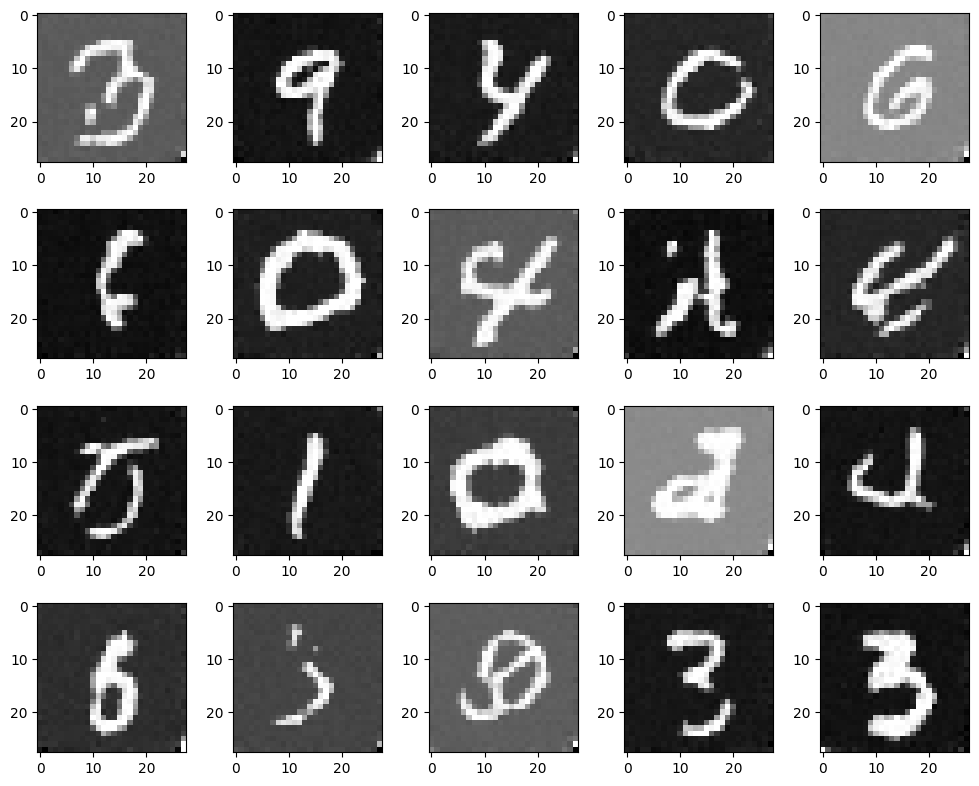

In [85]:
samples = diffusion_eps.sample(1000)
#samples = torch.clamp(samples, max=1)
_, _, test = convert_to_dataloader(*get_data(),create_config_eps())
test = next(iter(test))[:, :-1]
print(f"FID Score: {FID_dataset(samples, test)}")
display_images(samples.detach().cpu(), 4, 5)

## Comparing the 3 Different Models

By visual comparison and based on the FID score, it is clear that the last model, the so called `diffusion_eps`, is most effective. The digits that the model from Part 2 create are mostly clear digits than the other ones. That said, when we reduced the number of time-steps that also seemed to improve the quality of the generated digits. Regardless, the best results were when the neural network was trying to predict $\epsilon$ rather than $\mu$.